<h1> Keypoint Detection Model (Small Dataset) </h1>

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/root/alok/repos/cv_research/alok')

import glob
import json
import os
import numpy as np
from PIL import Image
from random import shuffle

import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
from keras.backend import tf as ktf

from matplotlib import pyplot as plt
from matplotlib import cm

from skimage.io import imread, imsave
from skimage.transform import resize
import math

%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="0"
np.random.seed(0)

Using TensorFlow backend.


<h1> Load Data </h1>

<h3> Create list of file paths for easy access in generator </h1>

In [2]:
crops_dir = '/root/data/alok/keypoint_detection/crops'
metadata_dir = '/root/data/alok/keypoint_detection/new_crop_metadata'

crop_fs = sorted(glob.glob(os.path.join(crops_dir, '*.jpg')))
metadata_fs = sorted(glob.glob(os.path.join(metadata_dir, '*.json')))
dataset = list(zip(crop_fs, metadata_fs))
dataset.pop(2)
dataset.pop(4)

('/root/data/alok/keypoint_detection/crops/left_blom-kjeppevikholmen_2_1548244619498_961_1148_3486_1921.jpg',
 '/root/data/alok/keypoint_detection/new_crop_metadata/left_blom-kjeppevikholmen_2_1548244619498_961_1148_3486_1921.json')

<h1> Define some constants </h1>

In [3]:
CLASSES = [
    'Body / Adipose Fin',
    'Body / Anal Fin',
    'Body / Dorsal Fin',
    'Body / Pectoral Fin',
    'Body / Pelvic Fin',
    'Bottom Corner of Tail',
    'Eye',
    'Top Corner of Tail',
    'Upper Lip'
]

<h1> Define helper functions for resizing crop and getting the corresponding keypoints </h1>

In [4]:
def get_transformed_crop_and_keypoints(crop_f, metadata_f, new_dims):
    crop = imread(crop_f)
    metadata = json.load(open(metadata_f))
    keypoints = metadata['keypoints']
    
    original_dims = np.array(crop).shape
    
    # get resized crop
    crop_resized = resize(crop, new_dims)
    
    # normalize cro
    crop_resized = crop_resized / 255.0
    
    transformed_keypoints_list = []
    for c in CLASSES:
        kp = keypoints[c]
        tkp_x = int(kp[0] * new_dims[0] / original_dims[1])
        tkp_y = int(kp[1] * new_dims[1] / original_dims[0])
        transformed_keypoints_list.append(tkp_x)
        transformed_keypoints_list.append(tkp_y)
    
    transformed_keypoints = np.array(transformed_keypoints_list)
    
    return crop_resized, transformed_keypoints
    
    
    
    
    


<h1> Define the Model </h1>

In [47]:
# Generate a model with all layers (with top)
vgg16 = VGG16(weights=, include_top=True)

#Add a layer where input is the output of the  second last layer 
x = Dense(18, name='predictions')(vgg16.layers[-2].output)

#Then create the corresponding model 
model = Model(input=vgg16.input, output=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  


<h1> Define the Generator </h1>

In [48]:
def data_generator(dset, steps_per_epoch, batch_size, input_shape, output_size):
    N = len(dset)
    i = 0
    while True:
        x_batch = np.empty((batch_size, *input_shape))
        y_batch = np.empty((batch_size, output_size))
        batch = dset[batch_size * i : min(batch_size * (i + 1), N)]
        for idx, d in enumerate(batch):
            crop_f, metadata_f = d
            crop_resized, transformed_keypoints = \
                get_transformed_crop_and_keypoints(crop_f, metadata_f, (input_shape[0], input_shape[1]))
            x_batch[idx, :] = crop_resized
            y_batch[idx, :] = transformed_keypoints
        
        i += 1
        if i > steps_per_epoch:
            i = 0
        yield x_batch, y_batch


In [49]:
BATCH_SIZE = 2
steps_per_epoch = math.ceil(len(dataset) / BATCH_SIZE)
input_shape = (224, 224, 3)
output_size = 18
gen = data_generator(dataset, steps_per_epoch, BATCH_SIZE, input_shape, output_size)


In [36]:
x, y = next(gen)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<h1> Train the Model </h1>

In [50]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
 
optimizer = keras.optimizers.adam(lr=0.0001, decay=0.1)
model.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.fit_generator(gen, steps_per_epoch=steps_per_epoch, epochs=100, verbose=True)

In [16]:
gen = data_generator(dataset, steps_per_epoch, BATCH_SIZE, input_shape, output_size)
predictions = model.predict_generator(gen, 7)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


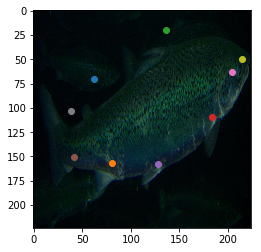

In [24]:
crop_resized, transformed_keypoints = get_transformed_crop_and_keypoints(crop_fs[0], metadata_fs[0], (224, 224))
plt.imshow(255 * crop_resized)
for i in range(9):
    kp_x = predictions[0][2*i]
    kp_y = predictions[0][2*i + 1]
    plt.scatter(kp_x, kp_y)
plt.show()

In [23]:
predictions[0]

array([ 62.464127,  69.803314,  81.01382 , 156.80745 , 136.26492 ,
        20.224392, 183.34818 , 109.06261 , 127.44959 , 157.26746 ,
        41.45005 , 150.30379 , 203.90785 ,  63.082573,  38.39821 ,
       102.69183 , 214.29315 ,  49.660503], dtype=float32)